# 准备数据

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original", data_home='./datasets/')
mnist

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

## 查看图片

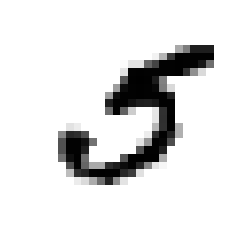

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000]

5.0

## 准备训练集和测试集

In [7]:
#划分
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#混洗
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 训练二元分类

In [10]:
# 数据集中所有为5的置为True,所有不为5的置为False
y_train_5 = (y_train == 5) 
y_test_5 = (y_test == 5)

In [11]:
#训练
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=300, tol=1e-3) #设置random_state来取得有复验性的结果
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=300,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([False])

# 性能评估

## 用交叉验证集测量精度

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9659, 0.9123, 0.9652])

In [14]:
# 预测所有的均为非5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9108 , 0.91015, 0.908  ])

## 混淆矩阵

In [15]:
# 使用cross_val_predict()预测
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [16]:
# 生成混淆矩阵
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52403,  2176],
       [  956,  4465]])

In [17]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

## [准确率和召回率](https://github.com/coldJune/machineLearning/blob/master/machineLearningCourseraNote/Note6.pdf)

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)# 4005/(4005+736)

0.6723385032374642

In [19]:
recall_score(y_train_5, y_train_pred)# 4005/(4005+1416)

0.823648773289061

In [20]:
# f1score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7403415685624275

## 准确率/召回率权衡

In [21]:
# 返回该实例的度量分数
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-2163.03121168])

In [22]:
threshold = 0
y_som_digit_pred = (y_scores > threshold)
y_som_digit_pred

array([False])

In [23]:
threshold = 5000
y_som_digit_pred = (y_scores > threshold)
y_som_digit_pred

array([False])

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")#使用decision_function代替predictions

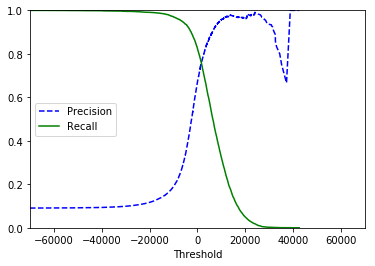

In [25]:
# 画出准确率和召回率的曲线
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.xlim([-70000, 70000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
#90%precision
y_train_pred_90 = (y_scores > 20000)
precision_score(y_train_5, y_train_pred_90)

0.9640287769784173

In [27]:
recall_score(y_train_5, y_train_pred_90)

0.04943737317838037

## [ROC曲线](http://coldjune.com/2018/05/23/AdaBoost%E5%85%83%E7%AE%97%E6%B3%95/#%E6%AD%A3%E7%A1%AE%E7%8E%87%E3%80%81%E5%8F%AC%E5%9B%9E%E7%8E%87%E5%8F%8AROC%E6%9B%B2%E7%BA%BF)

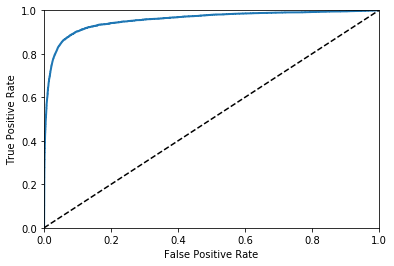

In [28]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.956072745446633

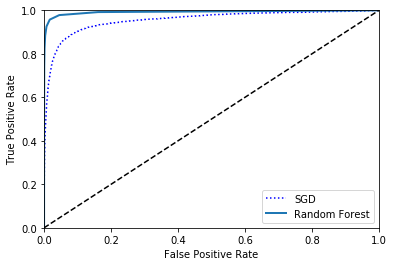

In [30]:
#随机森林的ROC曲线
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=10)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [31]:
roc_auc_score(y_train_5, y_scores_forest)

0.9924127198881463

# 多级分类

In [32]:
sgd_clf.fit(X_train, y_train)#底层训练了10个二元分类器，选择最大的
sgd_clf.predict([some_digit])

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([5.])

In [33]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -5287.43330114, -19788.75107011,  -8415.21071152,
         -4374.01213337, -12883.10312089,  -2163.03121168,
        -24277.84402694, -14398.80574419, -12106.08648388,
        -14263.00920975]])

In [34]:
np.argmax(some_digit_scores)

5

In [35]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [36]:
sgd_clf.classes_[5]

5.0

In [37]:
#使用一对一的训练器
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=500, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [38]:
len(ovo_clf.estimators_)

45

In [39]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

In [40]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.85062987, 0.87589379, 0.88698305])

In [42]:
# 缩减输入
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90976805, 0.91279564, 0.90788618])

# 误差分析

In [43]:
#首先查看混淆矩阵
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5667,    1,   20,    9,   10,   49,   36,    7,  120,    4],
       [   1, 6460,   46,   28,    5,   44,    6,    9,  127,   16],
       [  32,   31, 5310,   96,   79,   23,   77,   45,  254,   11],
       [  30,   23,  123, 5329,    1,  230,   30,   49,  240,   76],
       [  13,   17,   50,   14, 5298,    9,   41,   22,  179,  199],
       [  41,   23,   29,  171,   52, 4596,   90,   22,  310,   87],
       [  29,   19,   50,    2,   36,   98, 5591,    8,   85,    0],
       [  23,   11,   59,   26,   49,   11,    4, 5771,   75,  236],
       [  27,   73,   51,  107,    4,  127,   39,   11, 5335,   77],
       [  28,   25,   27,   81,  146,   31,    1,  177,  181, 5252]])

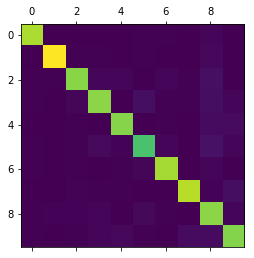

In [44]:
#使用图像显示矩阵
plt.matshow(conf_mx)
plt.show()

In [45]:
#画出误差
row_nums =conf_mx.sum(axis=1, keepdims=True)#计算每一类实际的数量
row_nums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [46]:
norm_conf_mx = conf_mx/row_nums# 计算错误比例
norm_conf_mx

array([[9.56778659e-01, 1.68833361e-04, 3.37666723e-03, 1.51950025e-03,
        1.68833361e-03, 8.27283471e-03, 6.07800101e-03, 1.18183353e-03,
        2.02600034e-02, 6.75333446e-04],
       [1.48323939e-04, 9.58172649e-01, 6.82290122e-03, 4.15307031e-03,
        7.41619697e-04, 6.52625334e-03, 8.89943637e-04, 1.33491546e-03,
        1.88371403e-02, 2.37318303e-03],
       [5.37092984e-03, 5.20308828e-03, 8.91238671e-01, 1.61127895e-02,
        1.32594830e-02, 3.86035582e-03, 1.29237999e-02, 7.55287009e-03,
        4.26317556e-02, 1.84625713e-03],
       [4.89316588e-03, 3.75142717e-03, 2.00619801e-02, 8.69189366e-01,
        1.63105529e-04, 3.75142717e-02, 4.89316588e-03, 7.99217093e-03,
        3.91453270e-02, 1.23960202e-02],
       [2.22526532e-03, 2.90996234e-03, 8.55871277e-03, 2.39643958e-03,
        9.06881205e-01, 1.54056830e-03, 7.01814447e-03, 3.76583362e-03,
        3.06401917e-02, 3.40636768e-02],
       [7.56318023e-03, 4.24275964e-03, 5.34956650e-03, 3.15439956e-02,
   

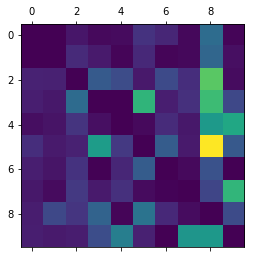

In [47]:
np.fill_diagonal(norm_conf_mx, 0)#将对角线置为0，只显示误差
plt.matshow(norm_conf_mx)#行越暗表示预测越正确，越亮表示误差越高
plt.show()

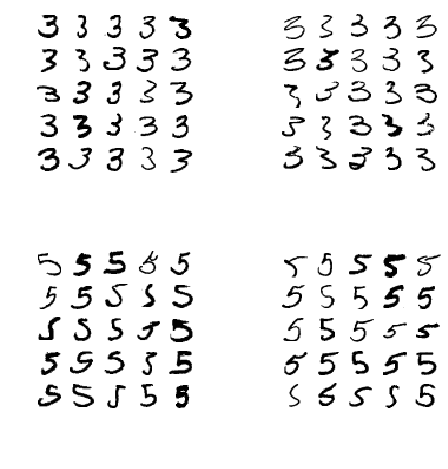

In [48]:
#画出所有的3和5
cl_3, cl_5 = 3, 5
X_33 = X_train[(y_train == cl_3) & (y_train_pred == cl_3)]#实际为3和预测为3
X_35 = X_train[(y_train == cl_3) & (y_train_pred == cl_5)]#实际为3和预测为5
X_53 = X_train[(y_train == cl_5) & (y_train_pred == cl_3)]#实际为5和预测为3
X_55 = X_train[(y_train == cl_5) & (y_train_pred == cl_5)]#实际为5和预测为5

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = images_per_row+1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap=matplotlib.cm.binary, **options)
    plt.axis("off")

    
plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_33[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_35[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_53[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_55[:25], images_per_row=5)

# 多标签分类

In [49]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [50]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [51]:
#计算F1
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9688059391891912

# 多路输出

In [52]:
#在图片数据上添加噪声
import numpy.random as rnd

noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

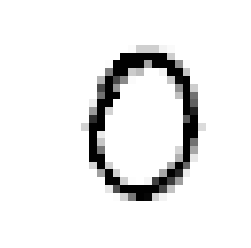

In [53]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[2]])
plot_digit(clean_digit)

# 练习

1.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
param_grid = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': np.arange(3, 6)}
]
knn_clf = KNeighborsClassifier()
grid_cv = GridSearchCV(knn_clf, param_grid, cv=3, n_jobs=5)
grid_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': array([3, 4, 5])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
grid_cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [16]:
grid_cv.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [17]:
from sklearn.metrics import accuracy_score
y_pred = grid_cv.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

2.

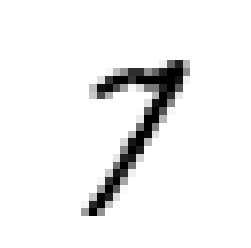

In [13]:
from scipy.ndimage.interpolation import shift

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
image = X_train[5].reshape(28, 28)
plot_digit(image)

In [14]:
def augmentation(data, x, y):
    data = data.reshape(28, 28)
    image = shift(data, [x, y], cval=0 )
    return image.reshape([-1])

In [15]:
x_train_aumentation = [image for image in X_train]
y_train_aumentation = [label for label in y_train]

for instance, label in zip(X_train, y_train):
    for x, y in [[0, 1], [0, -1], [-1, 0], [0, 1]]:
        image = augmentation(instance, x, y)
        x_train_aumentation.append(image)
        y_train_aumentation.append(label)

In [16]:
x_train_aumentation = np.array(x_train_aumentation)
y_train_aumentation = np.array(y_train_aumentation)

In [17]:
x_train_aumentation.shape

(300000, 784)

In [18]:
y_train_aumentation.shape

(300000,)

In [19]:
index = np.random.permutation(x_train_aumentation.shape[0])
x_train_aumentation = x_train_aumentation[index]
y_train_aumentation = y_train_aumentation[index]

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors= 4, weights='distance')

In [21]:
knn_clf.fit(x_train_aumentation, y_train_aumentation)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='distance')

In [ ]:
y_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.mode